[Reference](https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751)

In [6]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Data')

Mounted at /content/gdrive


In [70]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# NLP
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# t-SNE
from sklearn.manifold import TSNE

# adjust_text
# !pip install adjustText
from adjustText import adjust_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
main_data = pd.read_csv('News_Final.csv')
main_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


# Preprocessing

In [9]:
# Grab all the article titles
article_titles = main_data['Title']
article_titles.shape

(93239,)

In [15]:
# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)


# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['obama',
 'lays',
 'wreath',
 'arlington',
 'national',
 'cemetery',
 'look',
 'health',
 'chinese',
 'economy']

In [17]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz 

--2020-10-10 08:53:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  39.4MB/s    in 27s     

2020-10-10 08:53:45 (57.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

gzip: GoogleNews-vectors-negative300.bin..gz: No such file or directory


In [19]:
!gunzip GoogleNews-vectors-negative300.bin

In [20]:
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


300

In [21]:
economy_vec = model['economy']
economy_vec[:20] # First 20 components

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [23]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,-0.132812,-0.458984,-0.527344,0.139648,-0.123535,0.421875,-0.146484,0.041260,0.029907,-0.357422,0.044434,-0.093750,0.425781,-0.154297,-0.229492,0.300781,-0.427734,-0.080078,0.316406,-0.202148,0.103516,0.206055,-0.318359,-0.090820,-0.058105,0.099609,-0.225586,0.062988,0.200195,0.167969,...,0.371094,0.083984,0.234375,-0.308594,-0.302734,-0.239258,-0.187500,-0.218750,0.075684,-0.392578,-0.484375,0.146484,0.314453,0.125977,-0.135742,-0.158203,0.241211,-0.359375,0.065430,0.136719,-0.131836,-0.076172,-0.049805,0.267578,-0.562500,-0.191406,0.006439,-0.333984,0.147461,-0.392578,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,-0.375000,0.326172,0.050049,0.055664,0.005920,0.212891,0.047852,0.287109,-0.300781,0.249023,-0.097168,0.116699,-0.161133,0.233398,0.191406,-0.300781,-0.189453,0.123047,-0.215820,0.253906,-0.245117,-0.186523,-0.205078,0.312500,-0.027954,-0.210938,0.045166,0.209961,0.203125,0.068359,...,-0.269531,-0.271484,-0.050293,-0.108887,-0.058594,0.283203,-0.243164,-0.196289,-0.128906,-0.098633,0.047363,0.051270,-0.042236,-0.065918,-0.090332,0.119629,0.041260,0.231445,-0.079590,0.367188,-0.231445,0.030151,0.059570,0.333984,0.238281,0.030273,-0.183594,0.229492,-0.024902,-0.101562,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,0.114746,-0.101562,-0.137695,0.073242,-0.088379,-0.021118,-0.400391,-0.011169,-0.177734,-0.371094,0.332031,0.429688,-0.027954,-0.247070,0.087402,0.170898,-0.109863,-0.120117,-0.269531,-0.144531,-0.221680,-0.197266,-0.168945,0.088867,0.326172,-0.443359,0.316406,0.077148,-0.437500,-0.049805,...,-0.028076,0.363281,-0.425781,-0.542969,0.227539,0.451172,0.078125,0.099121,-0.466797,0.059814,-0.019653,0.038574,0.038574,-0.154297,0.294922,-0.076660,0.265625,0.263672,-0.410156,0.117188,-0.159180,0.166016,0.130859,0.223633,0.082031,0.060791,-0.157227,0.419922,0.009460,0.040527,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477


# t-SNE

In [30]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


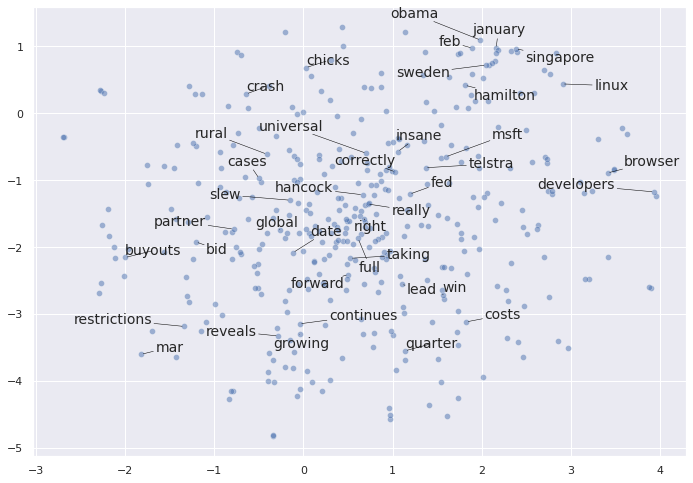

In [31]:
sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

# Averaging Word Embeddings

In [32]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [34]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

37 docs removed
0 docs removed


# t-SNE for Document Vectors

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


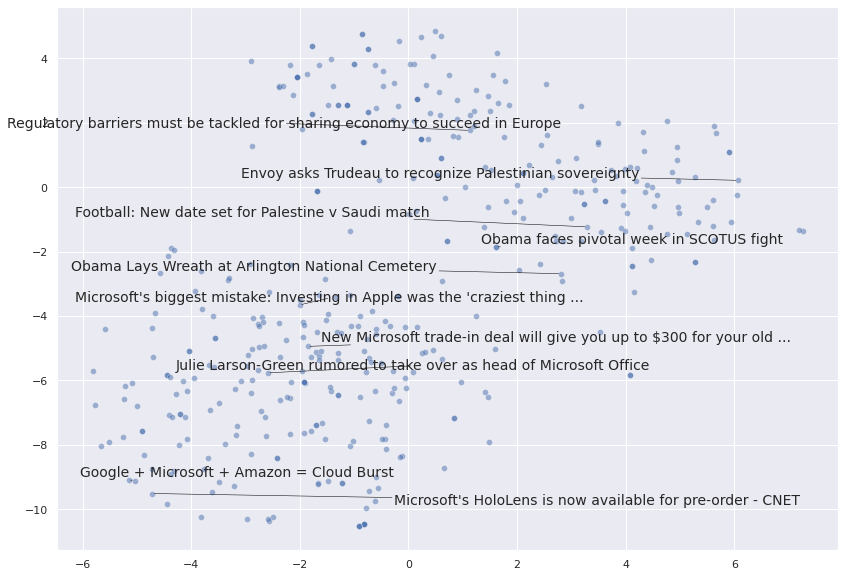

In [36]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

# Popularity and Sentiment Analysis

In [37]:
# Drop all the rows where the article popularities are unknown (this is only about 11% of the data)
main_data = main_data.drop(main_data[(main_data.Facebook == -1) | 
                                     (main_data.GooglePlus == -1) | 
                                     (main_data.LinkedIn == -1)].index)

# Also drop all rows where we don't know the source
main_data = main_data.drop(main_data[main_data['Source'].isna()].index)

main_data.shape

(81417, 11)

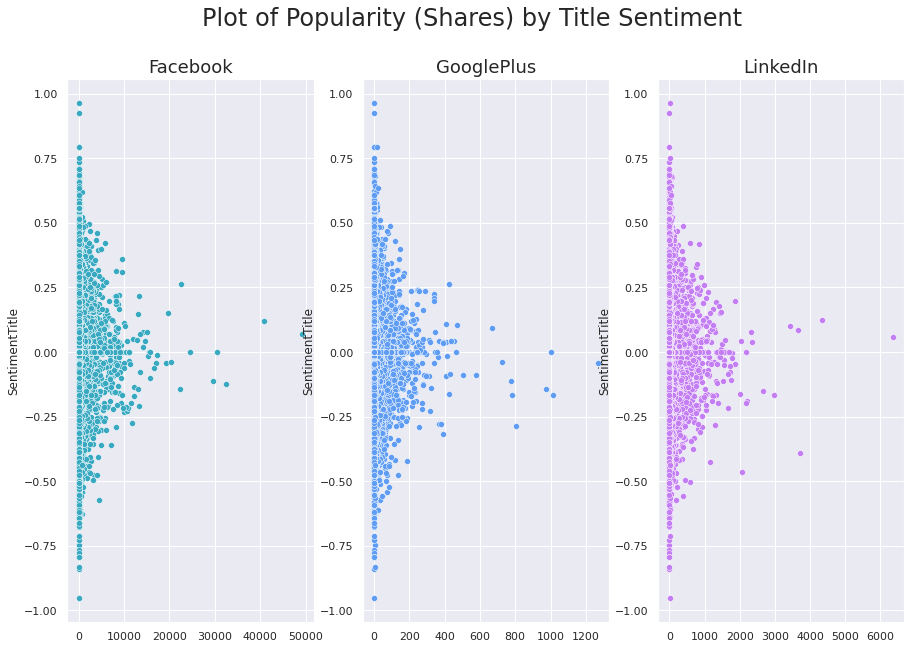

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

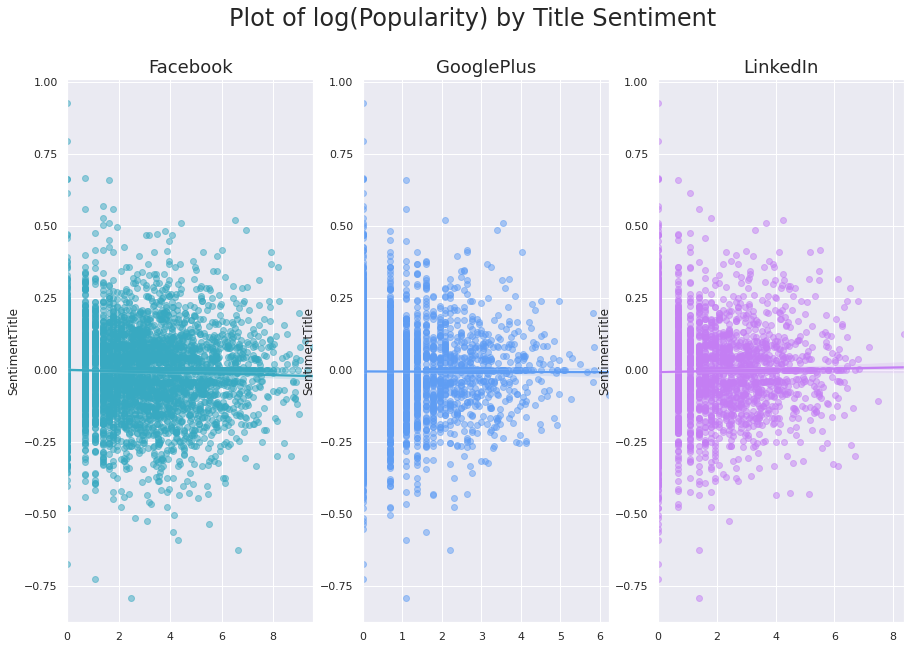

In [39]:
# Our data has over 80,000 rows, so let's also subsample it to make the log-transformed scatterplot easier to read

subsample = main_data.sample(5000)

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]

for platform, subplot, color in zip(platforms, subplots, colors):
    # Regression plot, so we can gauge the linear relationship
    sns.regplot(x = np.log(subsample[platform] + 1), y = subsample['SentimentTitle'], 
                ax=subplot, 
                color=color,
                # Pass an alpha value to regplot's scatterplot call
                scatter_kws={'alpha':0.5})
    
    # Set a nice title, get rid of x labels
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of log(Popularity) by Title Sentiment', fontsize=24)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

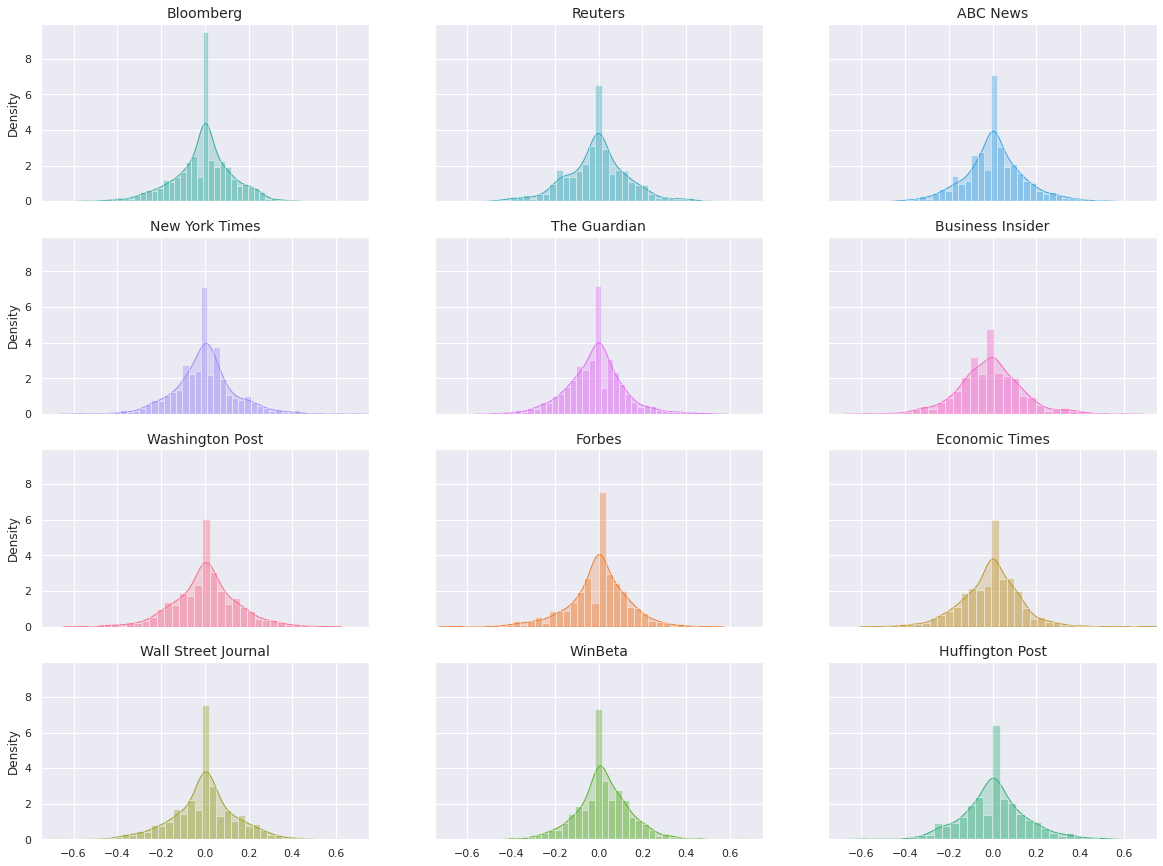

In [40]:
# Get the list of top 12 sources by number of articles
source_names = list(main_data['Source'].value_counts()[:12].index)
source_colors = list(sns.husl_palette(12, h=.5))

fig, ax = plt.subplots(4, 3, figsize=(20, 15), sharex=True, sharey=True)

ax = ax.flatten()
for ax, source, color in zip(ax, source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, color=color, kde_kws={'shade':True})
    ax.set_title(source, fontsize=14)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

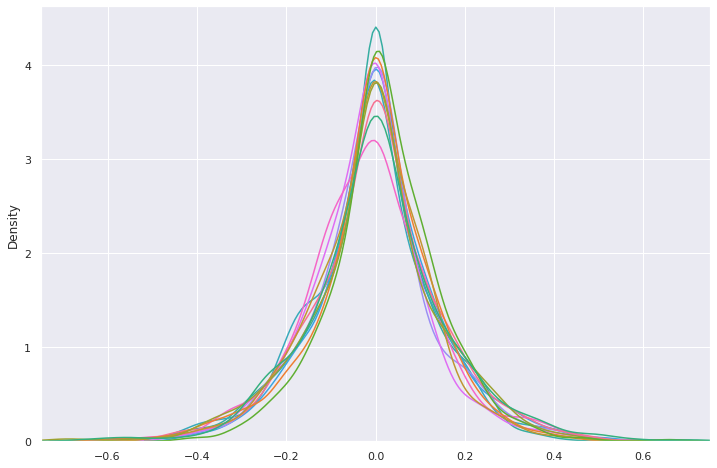

In [41]:
# Overlay each density curve on the same plot for closer comparison

fig, ax = plt.subplots(figsize=(12, 8))

for source, color in zip(source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, hist=False, label=source, color=color)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

In [42]:
# Group by Source, then get descriptive statistics for title sentiment
source_info = main_data.groupby('Source')['SentimentTitle'].describe()
# Recall that `source_names` contains the top 12 sources
# We'll also sort by highest standard deviation
source_info.loc[source_names].sort_values('std', ascending=False)[['std', 'min', 'max']]

,std,min,max
Source,,,
Huffington Post,0.158071,-0.644314,0.711512
Wall Street Journal,0.152442,-0.711512,0.617945
Business Insider,0.148298,-0.557338,0.573742
Washington Post,0.146626,-0.530340,0.504280
Reuters,0.145920,-0.585573,0.676516
New York Times,0.141851,-0.555912,0.662913
ABC News,0.141676,-0.424931,0.795495
Forbes,0.138622,-0.618718,0.455132
Bloomberg,0.138444,-0.632712,0.612372


In [44]:
# Convert publish date column to make it compatible with other datetime objects

main_data['PublishDate'] = pd.to_datetime(main_data['PublishDate'])

# Time since Linux Epoch
t = datetime.datetime(1970, 1, 1)

# Subtract this time from each article's publish date
main_data['TimeSinceEpoch'] = main_data['PublishDate'] - t

# Create another column for just the days from the timedelta objects 
main_data['DaysSinceEpoch'] = main_data['TimeSinceEpoch'].astype('timedelta64[D]')

main_data['TimeSinceEpoch'].describe()

count                            81417
mean     16859 days 20:08:20.439018240
std         64 days 18:03:50.779344326
min                16747 days 05:25:00
25%                16805 days 20:54:00
50%                16857 days 06:04:23
75%                16913 days 08:15:00
max                16989 days 15:59:22
Name: TimeSinceEpoch, dtype: object

In [46]:
pca = PCA(n_components=15, random_state=10)

# as a reminder, x is the array with our 300-dimensional vectors
reduced_vecs = pca.fit_transform(x)
df_w_vectors = pd.DataFrame(reduced_vecs)

df_w_vectors['Title'] = titles_list# Use pd.concat to match original titles with their vectors
main_w_vectors = pd.concat((df_w_vectors, main_data), axis=1)

# Get rid of vectors that couldn't be matched with the main_df
main_w_vectors.dropna(axis=0, inplace=True)
main_w_vectors.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Title,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,TimeSinceEpoch,DaysSinceEpoch
726,0.609940,-0.378288,-0.134879,0.009159,0.104013,0.144600,-0.154347,-0.165059,0.007241,-0.028555,0.039511,0.070406,-0.007659,-0.042755,0.025391,Microsoft offering £100 discount on original B...,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0.0,0.0,0.0,16747 days 05:25:00,16747.0
727,-0.540923,-0.411112,-0.179319,-0.234198,0.079569,-0.047383,-0.128542,-0.044863,-0.006586,-0.173695,-0.252550,0.067611,-0.005423,-0.095768,-0.153199,Economy to improve though no change in last 6 ...,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0.0,0.0,0.0,16747 days 05:40:00,16747.0
728,-0.540923,-0.411112,-0.179319,-0.234198,0.079569,-0.047383,-0.128542,-0.044863,-0.006586,-0.173695,-0.252550,0.067611,-0.005423,-0.095768,-0.153199,Economy to improve though no change in last 6 ...,227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0.0,0.0,0.0,16747 days 05:48:00,16747.0
729,0.497379,-0.475762,-0.159874,-0.162787,0.012210,0.077634,-0.078562,-0.061359,-0.139634,0.058867,-0.088947,-0.101854,0.067350,-0.005119,0.059112,Microsoft scales back free online storage plans,307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0.0,0.0,0.0,16747 days 06:54:00,16747.0
730,-0.160429,-0.275590,0.342958,0.119426,0.154864,0.243778,0.174679,0.224618,-0.021123,0.018616,0.127843,0.031346,-0.049639,-0.133023,0.015596,IDC predicts the emergence of ‘DX economy’,207.0,IDC predicts the emergence of ‘DX economy’,KUCHING: The global digital economy is about t...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1.0,0.0,0.0,16747 days 08:34:00,16747.0


In [48]:
# Drop all non-numeric, non-dummy columns, for feeding into the models
cols_to_drop = ['IDLink', 'Title', 'TimeSinceEpoch', 'Headline', 'PublishDate', 'Source'] 

data_only_df = pd.get_dummies(main_w_vectors, columns = ['Topic']).drop(columns=cols_to_drop)

# Standardize DaysSinceEpoch since the raw numbers are larger in magnitude 

scaler = StandardScaler()

# Reshape so we can feed the column to the scaler
standardized_days = np.array(data_only_df['DaysSinceEpoch']).reshape(-1, 1)
data_only_df['StandardizedDays'] = scaler.fit_transform(standardized_days)

# Drop the raw column; we don't need it anymore
data_only_df.drop(columns=['DaysSinceEpoch'], inplace=True)

# Look at the new range
data_only_df['StandardizedDays'].describe()

count    8.139800e+04
mean    -6.155442e-14
std      1.000006e+00
min     -1.734555e+00
25%     -8.386800e-01
50%     -3.548197e-02
75%      8.295005e-01
max      2.003405e+00
Name: StandardizedDays, dtype: float64

In [52]:
# Get Facebook data only
fb_data_only_df = data_only_df.drop(columns=['GooglePlus', 'LinkedIn'])# Separate the features and the response
X = fb_data_only_df.drop('Facebook', axis=1)
y = fb_data_only_df['Facebook']

# 80% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [53]:
# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

[09:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


311080.196258854

In [54]:
# Various hyper-parameters to tune
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [250]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  4.4min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'm

In [55]:
# Give it 200 estimators, 100 is just a restriction to make the grid search run faster
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 200, 'nthread': 4, 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgc = xgb.XGBClassifier(random_state=10, **params)

In [56]:
# Define a quick function that will return 1 (true) if the article has 0-1 share(s)
def dud_finder(popularity):
    if popularity <= 1:
        return 1
    else:
        return 0# Create target column using the function
fb_data_only_df['is_dud'] = fb_data_only_df['Facebook'].apply(dud_finder)
fb_data_only_df[['Facebook', 'is_dud']].head()

,Facebook,is_dud
726,0.0,1
727,0.0,1
728,0.0,1
729,0.0,1
730,1.0,1


In [57]:
# 28% of articles can be classified as "duds"
fb_data_only_df['is_dud'].sum() / len(fb_data_only_df)

0.2831273495663284

In [58]:
X = fb_data_only_df.drop(['is_dud', 'Facebook'], axis=1)
y = fb_data_only_df['is_dud']

# 70% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

#lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=10)
#xgc = xgb.XGBClassifier(random_state=10)
rfc = RandomForestClassifier(n_estimators=100, random_state=10)
knn = KNeighborsClassifier()

preds = {}
for model_name, model in zip(['XGClassifier', 'RandomForestClassifier', 'KNearestNeighbors'], [xgc, rfc, knn]):
    model.fit(X_train, y_train)
    preds[model_name] = model.predict(X_test)

In [60]:
for k in preds:
    print("{} performance:".format(k))
    print()
    print(classification_report(y_test, preds[k]), sep='\n')

XGClassifier performance:

              precision    recall  f1-score   support

           0       0.72      1.00      0.84     11694
           1       0.50      0.00      0.00      4586

    accuracy                           0.72     16280
   macro avg       0.61      0.50      0.42     16280
weighted avg       0.66      0.72      0.60     16280

RandomForestClassifier performance:

              precision    recall  f1-score   support

           0       0.72      0.97      0.83     11694
           1       0.38      0.05      0.09      4586

    accuracy                           0.71     16280
   macro avg       0.55      0.51      0.46     16280
weighted avg       0.63      0.71      0.62     16280

KNearestNeighbors performance:

              precision    recall  f1-score   support

           0       0.73      0.85      0.78     11694
           1       0.35      0.21      0.26      4586

    accuracy                           0.67     16280
   macro avg       0.54      0.5

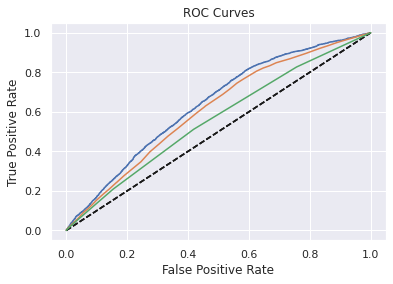

In [61]:
# Plot ROC curves
for model in [xgc, rfc, knn]:
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

# Popularity Prediction

In [63]:
averaged_probs = (xgc.predict_proba(X)[:, 1] +
                  knn.predict_proba(X)[:, 1] + 
                  rfc.predict_proba(X)[:, 1]) / 3
X['prob_dud'] = averaged_probs
y = fb_data_only_df['Facebook']

In [64]:
# Reinitialize the train_test_split since we've changed back to regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Another round of hyperparameter tuning
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, .05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [250]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  4.5min finished


0.0357666275449679
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [65]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgr = xgb.XGBRegressor(random_state=2, **params)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=250,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [66]:
y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

314072.8297954899

In [71]:
mean_absolute_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))

(179.5695520526709, 560.4220104488134)

In [72]:
for feature, importance in zip(list(X.columns), xgr.feature_importances_):
    print('Model weight for feature {}: {}'.format(feature, importance))

Model weight for feature 0: 0.040726687759160995
Model weight for feature 1: 0.04179830476641655
Model weight for feature 2: 0.033167172223329544
Model weight for feature 3: 0.05697639286518097
Model weight for feature 4: 0.024826984852552414
Model weight for feature 5: 0.05430616810917854
Model weight for feature 6: 0.050015345215797424
Model weight for feature 7: 0.0350613072514534
Model weight for feature 8: 0.03997410461306572
Model weight for feature 9: 0.0534394271671772
Model weight for feature 10: 0.07518506050109863
Model weight for feature 11: 0.05287164822220802
Model weight for feature 12: 0.017834631726145744
Model weight for feature 13: 0.04189450293779373
Model weight for feature 14: 0.0749039500951767
Model weight for feature SentimentTitle: 0.022913463413715363
Model weight for feature SentimentHeadline: 0.04443860426545143
Model weight for feature Topic_economy: 0.021937716752290726
Model weight for feature Topic_microsoft: 0.04569283127784729
Model weight for feature